In [ ]:
import albumentations as A
import cv2
import numpy as np
from google.colab import drive
image_size = 512
import imgaug
imgaug.random.seed(123)
import random
random.seed(7)

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create transforms to augment data

In [ ]:
mult = -(image_size//-9)
transform = A.Compose([
    A.RandomScale(scale_limit=.1),
    A.Resize(9*mult,16*mult),
    #A.RandomRotate90(),
    A.RandomCrop(width=image_size, height=image_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=.5,brightness_limit=.3,contrast_limit=.3),
    #A.ColorJitter(p=.5),
])
testtransform = A.Compose([
    #A.RandomScale(scale_limit=(2,3)),
    A.Resize(9*mult,16*mult),
    #A.RandomRotate90(),
    A.CenterCrop(width=image_size, height=image_size),
    A.HorizontalFlip(p=0.5),
])

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


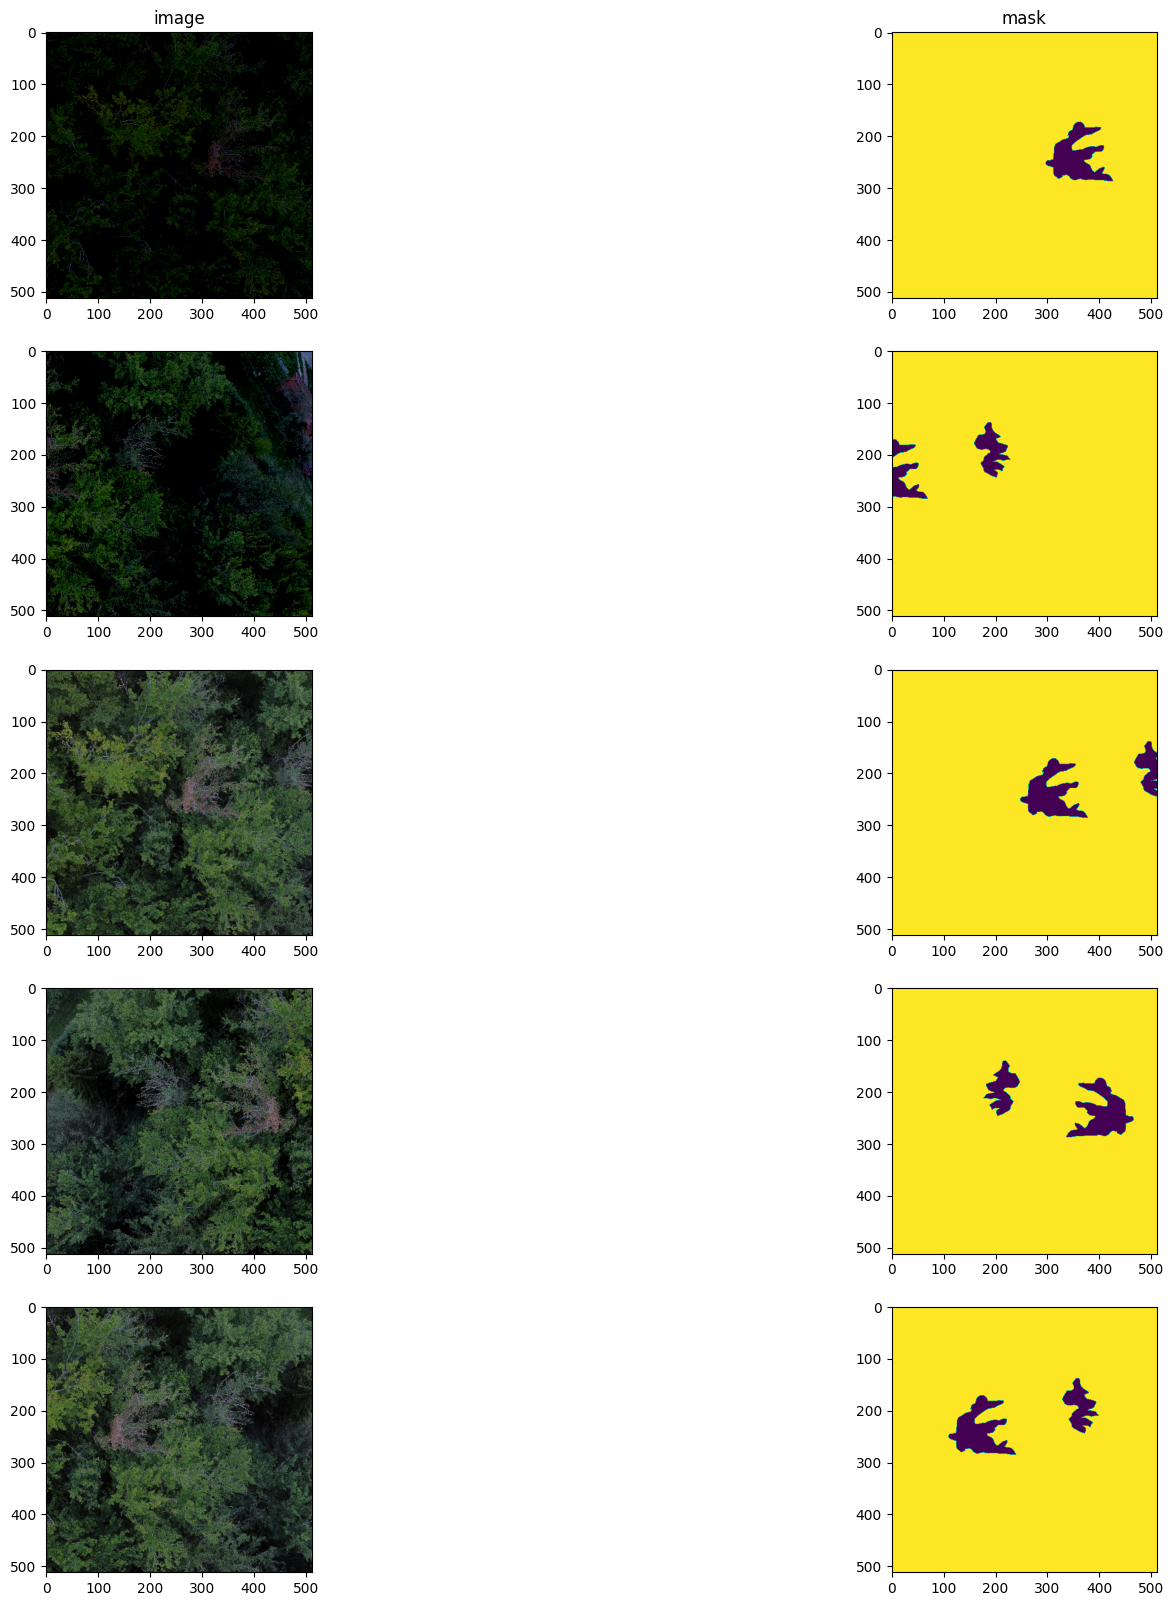

In [ ]:
from matplotlib import pyplot as plt

image = cv2.imread('drive/MyDrive/tree_segmentation/original/sick/image/DJI_0033.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread('drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0033.png', cv2.IMREAD_GRAYSCALE)

N = 5
f, ax = plt.subplots(N, 2, figsize=(20, 20))
ax[0][0].set_title("image")
ax[0][1].set_title("mask")
for i in range(N):
  HealthyMask = True
  while HealthyMask:
    transformed = transform(image=image,mask=mask)
    #run until at least 10% of pixels are of sick trees so we get an interesting image
    HealthyMask = np.sum(transformed['mask']!=255)>.1*image_size**2
  ax[i][0].imshow(transformed['image'])
  ax[i][1].imshow(transformed['mask'])


In [ ]:
import glob
sick_images = glob.glob('drive/MyDrive/tree_segmentation/original/sick/image/*.JPG')
sick_masks = glob.glob('drive/MyDrive/tree_segmentation/original/sick/mask/*.png')
healthy_images = glob.glob('drive/MyDrive/tree_segmentation/original/healthy/image/*.JPG')
healthy_masks = glob.glob('drive/MyDrive/tree_segmentation/original/healthy/mask/*.png')

sick_images.sort()
sick_masks.sort()
healthy_images.sort()
healthy_masks.sort()

sick = []
healthy = []
for i,m in zip(sick_images,sick_masks):
  sick.append({'image':i,'mask':m})

for i in healthy_images:
  healthy.append({'image':i,'mask':healthy_masks[0]})

print(sick)
print(healthy)

[{'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0031.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0031.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0032.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0032.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0033.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0033.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0034.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0034.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0035.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0035.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0036.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0036.png'}, {'image': 'drive/MyDrive/tree_segmentation/original

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
total_sick = len(sick_images)
#add in some healthy images
total_healthy = len(healthy_images)
healthy_to_use = round(total_sick*.2)
healthy_idx = np.random.choice(total_healthy,healthy_to_use)
filepaths = tf.data.Dataset.from_tensor_slices((sick_images+[healthy_images[i] for i in healthy_idx],sick_masks+healthy_masks*healthy_to_use))
#filepaths = tf.data.Dataset.from_tensor_slices((sick_images,sick_masks))

In [ ]:
def load_and_preprocess_image(image_path, mask_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.uint8)
    #image = tf.image.convert_image_dtype(image, tf.float32)

    # Load and preprocess the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, dtype=tf.uint8)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = 1-tf.math.round(mask)  # Ensure binary mask (0 or 1) #invert mask

    return image, mask

In [ ]:
dataset = filepaths.map(load_and_preprocess_image)

In [ ]:
total_samples = len(dataset)#+len(healthy_images)
print(total_samples)
train_size = round(0.8 * total_samples)
print(train_size)
validation_size = total_samples - train_size
print(validation_size)
dataset = dataset.shuffle(100,seed=10)

train_dataset,validation_dataset = tf.keras.utils.split_dataset(dataset,left_size=.8)

31
25
6


In [ ]:
def apply_augmentation(image,mask):
  transformed = transform(image=image,mask=mask)
  aug_img = transformed["image"]
  aug_img = tf.cast(aug_img/255, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[image_size, image_size])
  aug_mask = transformed["mask"]
  aug_mask = tf.cast(aug_mask, tf.float32)
  aug_mask = tf.image.resize(aug_mask, size=[image_size, image_size])
  return aug_img, aug_mask

def process_data(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=apply_augmentation, inp=[image, mask], Tout=(tf.float32, tf.float32))
    aug_img.set_shape((image_size,image_size,3))
    aug_mask.set_shape((image_size,image_size,1))
    return aug_img, aug_mask

def apply_augmentation_test(image,mask):
  transformed = testtransform(image=image,mask=mask)
  aug_img = transformed["image"]
  aug_img = tf.cast(aug_img/255, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[image_size, image_size])
  aug_mask = transformed["mask"]
  aug_mask = tf.cast(aug_mask, tf.float32)
  aug_mask = tf.image.resize(aug_mask, size=[image_size, image_size])
  return aug_img, aug_mask

def process_data_test(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=apply_augmentation_test, inp=[image, mask], Tout=(tf.float32, tf.float32))
    aug_img.set_shape((image_size,image_size,3))
    aug_mask.set_shape((image_size,image_size,1))
    return aug_img, aug_mask


In [ ]:
augmented_dataset = dataset.map(process_data).batch(32).prefetch(AUTOTUNE)

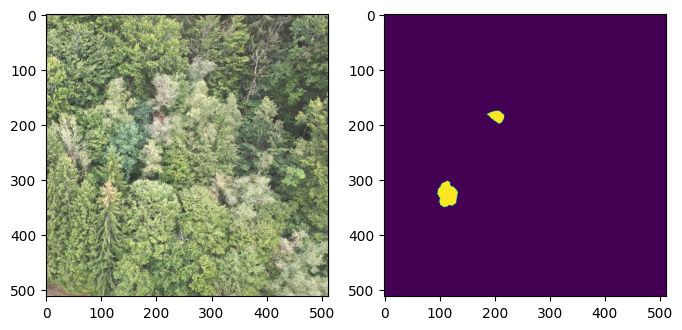

In [ ]:
def view_image(ds):
    image, mask = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    mask = mask.numpy()
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(image[0])
    ax[1].imshow(mask[0])

view_image(augmented_dataset)

In [ ]:
TRAIN_LENGTH = train_size
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_batches = (
    train_dataset
    .map(process_data)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

#test_batches = validation_dataset.map(process_data_test).batch(BATCH_SIZE).repeat()
test_batches = (
    validation_dataset
    .map(process_data_test)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    #.repeat()
    #.prefetch(buffer_size=tf.data.AUTOTUNE))
  )
final_batches = validation_dataset.map(process_data_test).batch(BATCH_SIZE)
type(train_batches)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Original Image', 'Original Mask', 'Generated Mask', 'Heat Map']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

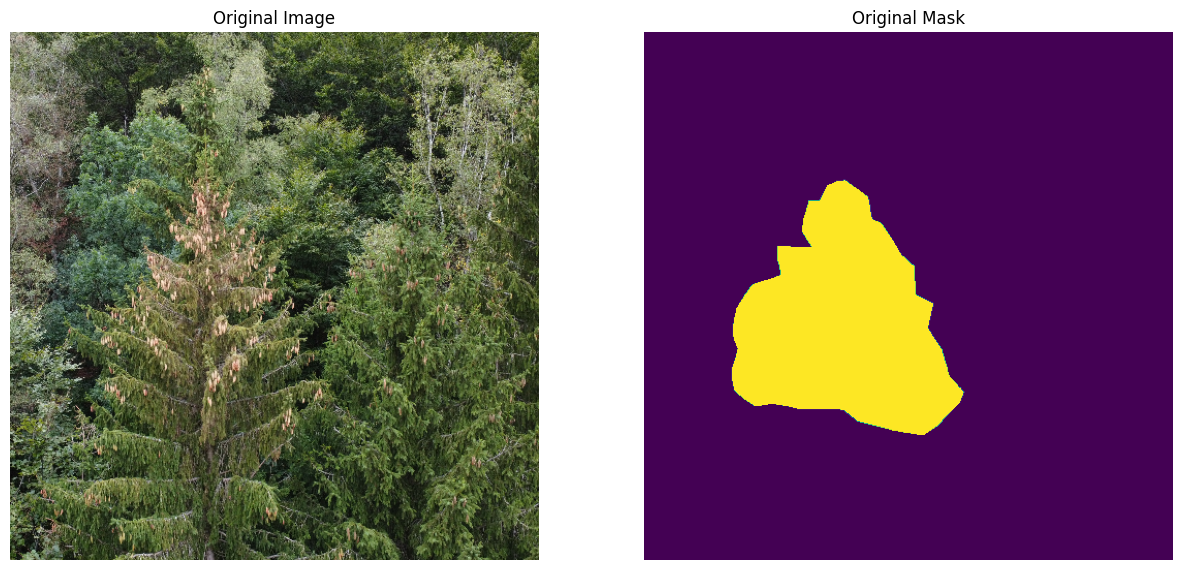

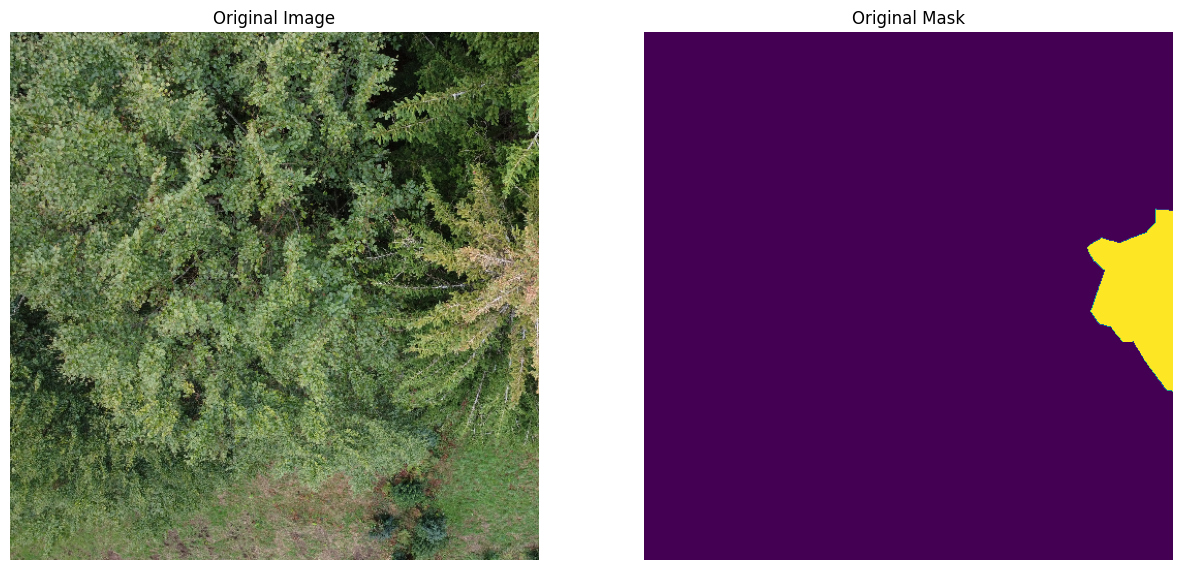

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[image_size, image_size, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


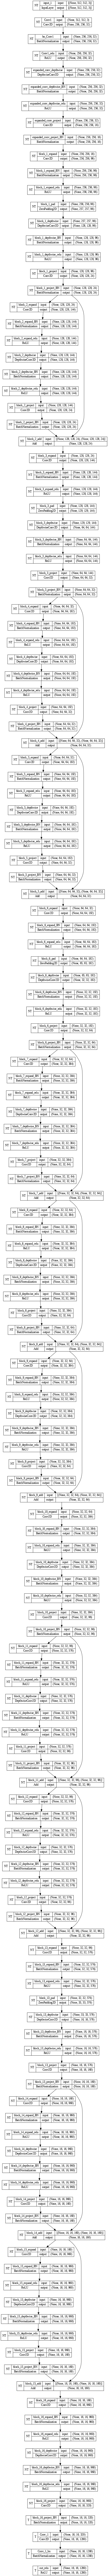

In [ ]:
tf.keras.utils.plot_model(base_model,show_shapes=True,dpi=60,show_layer_names=True,show_trainable=True)

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-357sm15i
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-357sm15i
  Resolved https://github.com/tensorflow/examples.git to commit 0b14ce1c88537b94772cc99d995d936417be6f5d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1699471818.63262868223049538191520590201343318150499692381-py3-none-any.whl size=301556 sha256=8e9025b0c71a93adae6dfd209bd45f920f76e63c1b9c4213252d365043423881
  Stored in directory: /tmp/pip-ephem-wheel-cache-8b9vnopi/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[image_size, image_size, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> image_sizeximage_size

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

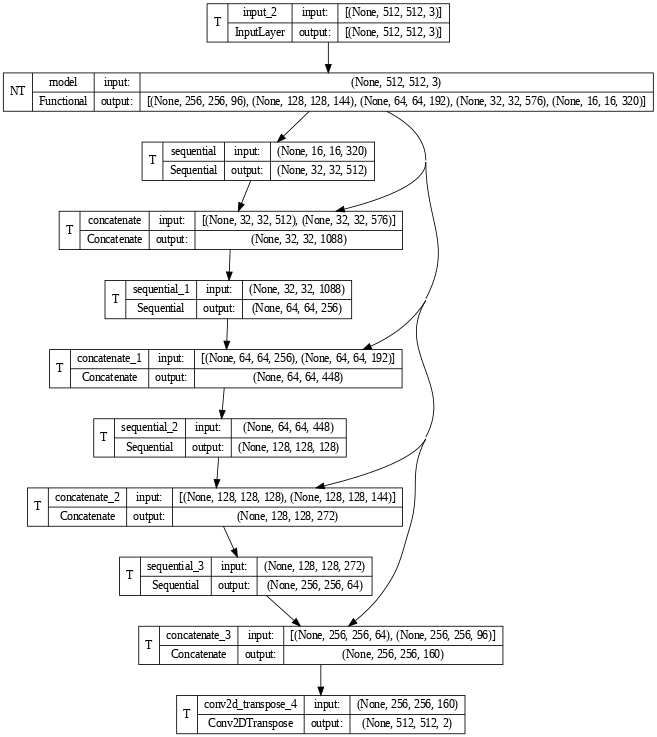

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=60,show_layer_names=True,show_trainable=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      #display([image[0], mask[0], create_mask(pred_mask)])
      for i in range(BATCH_SIZE):
        try:
          display([image[i], mask[i], create_mask(pred_mask[i]), (pred_mask[:,:,:,1, tf.newaxis])[i]])
        except:
          pass
  else:
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image, sample_mask,create_mask(pred_mask[0]), (pred_mask[:,:,:,1, tf.newaxis])[0]])

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 22ms/step


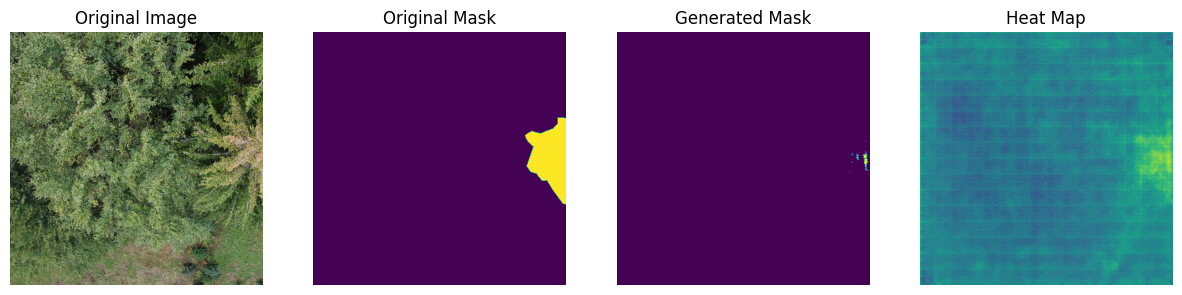


Sample Prediction after epoch 20


Epoch 20: val_loss did not improve from 0.09141
25/25 [==============================] - 2s 71ms/step - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.2377 - val_accuracy: 0.9575


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 20
VALIDATION_STEPS = len(validation_dataset)

filepath = 'segmentation_model2.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=len(train_dataset),
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(),checkpoint])

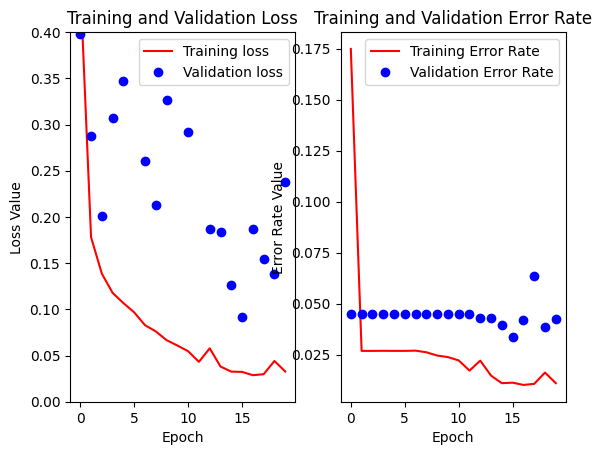

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure()
plt.subplot(121)
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, .4])
plt.legend()

error = 1-np.array(model_history.history['accuracy'])
val_error = 1-np.array(model_history.history['val_accuracy'])
plt.subplot(122)
#plt.figure()
plt.plot(model_history.epoch, error, 'r', label='Training Error Rate')
plt.plot(model_history.epoch, val_error, 'bo', label='Validation Error Rate')
plt.title('Training and Validation Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate Value')
#plt.ylim([8,. 1])
plt.legend()
plt.show()

1/1 [==============================] - 1s 783ms/step


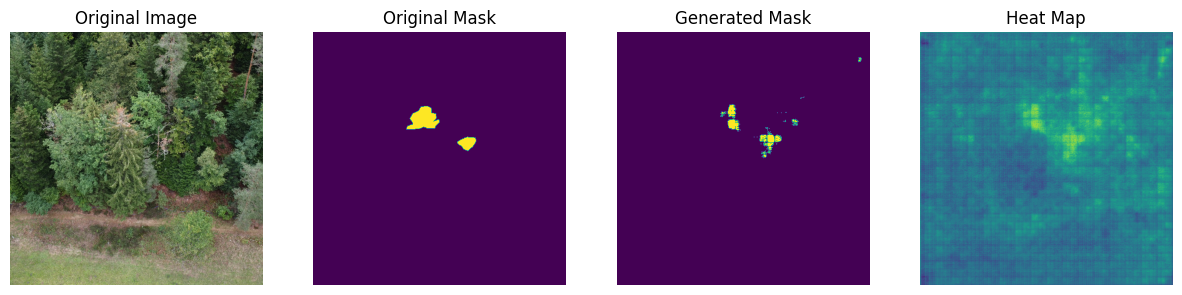

1/1 [==============================] - 0s 39ms/step


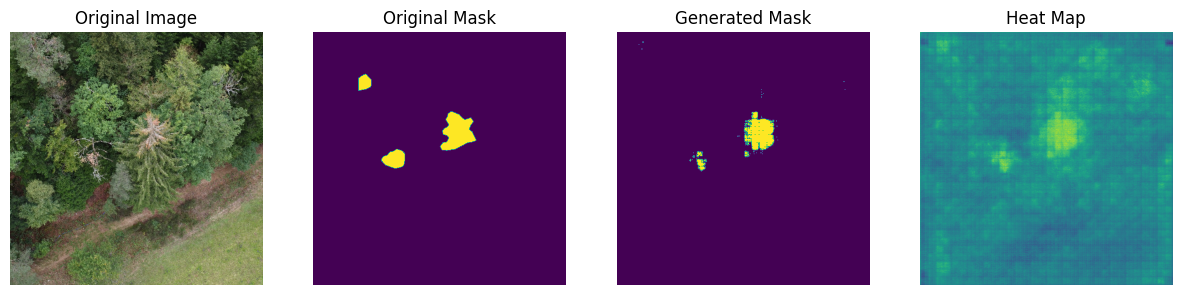

1/1 [==============================] - 0s 40ms/step


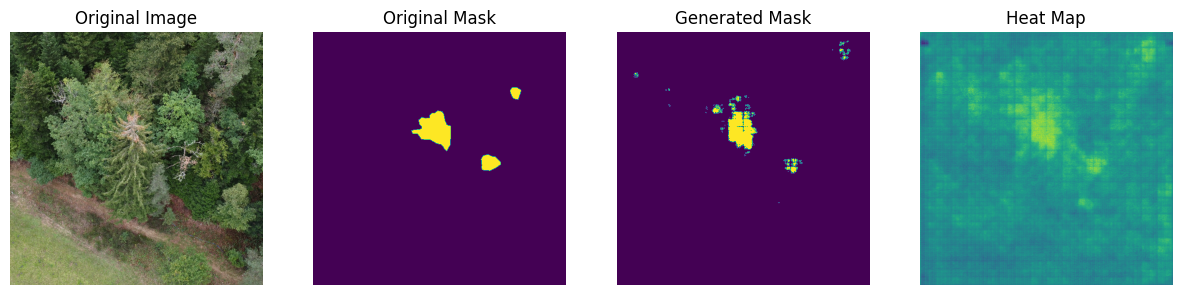

1/1 [==============================] - 0s 32ms/step


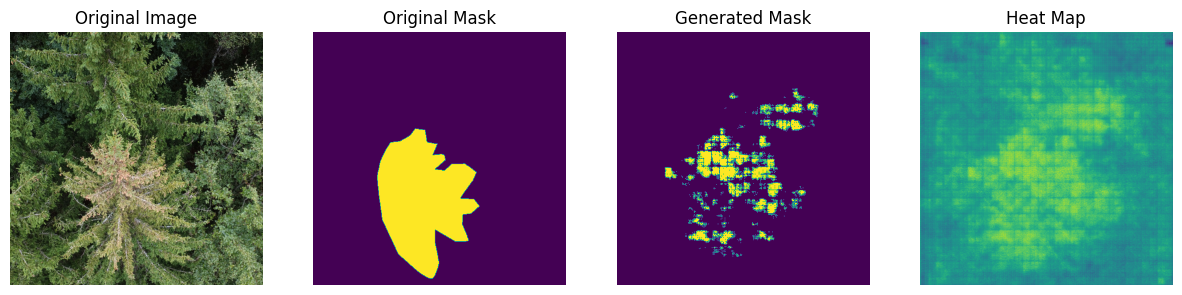

1/1 [==============================] - 0s 32ms/step


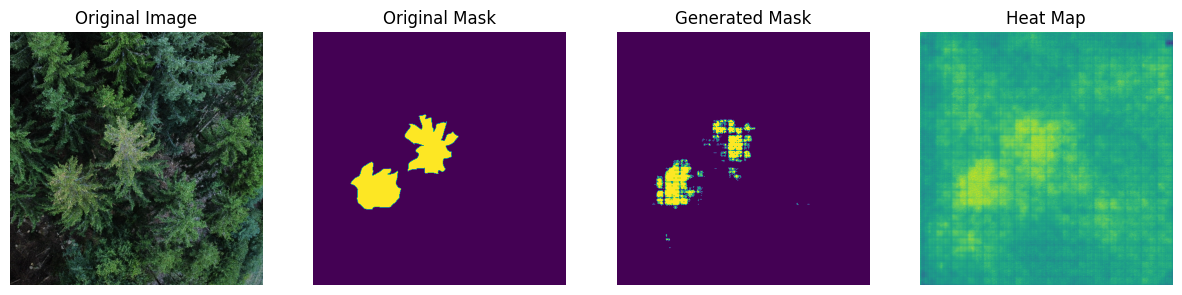

1/1 [==============================] - 0s 36ms/step


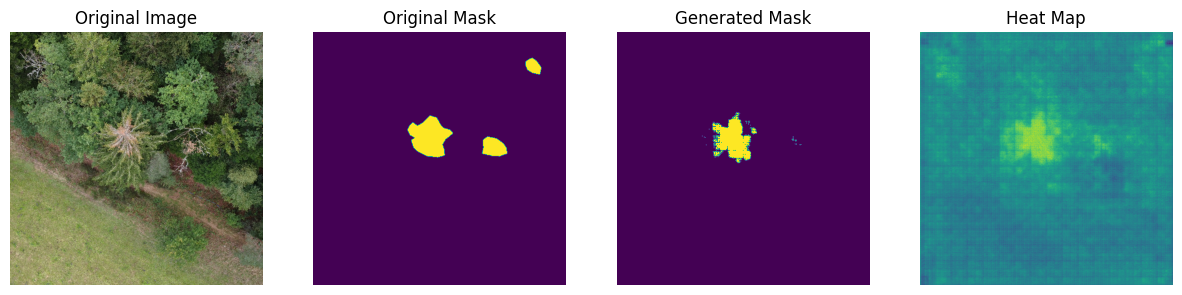

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(filepath)
show_predictions(final_batches, 20)


In [ ]:
random_seed = 20
dataset = filepaths.map(load_and_preprocess_image)
dataset = dataset.shuffle(100,seed=10)
nfolds = 10
EPOCHS = 20

datafolds =[]
#create the folds
for i in range(nfolds):
  datafolds.append(dataset.shard(nfolds,i))

val_loss = []
score  = []
#take one fold as the test validation set and the rest as the test set
for i in range(nfolds):
  test = datafolds[i]
  trainlist = [datafolds[n] for n in range(nfolds) if n!=i]
  train = trainlist[0]
  for t in trainlist[1:]:
    train.concatenate(t)

  train_batches = (
      train
      .map(process_data)
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .repeat()
      .prefetch(buffer_size=tf.data.AUTOTUNE))

  test_batches = (
      test
      .map(process_data_test)
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE))
      #.repeat()
      #.prefetch(buffer_size=tf.data.AUTOTUNE))

  VALIDATION_STEPS = len(test)

  #now run the model and collect scores
  model = unet_model(output_channels=OUTPUT_CLASSES)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=len(train),
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)
  val_loss.append(model_history.history['val_loss'])
  score.append(min(model_history.history['val_loss']))

Epoch 1/20
3/3 [==============================] - 17s 3s/step - loss: 0.6713 - accuracy: 0.5978 - val_loss: 0.3064 - val_accuracy: 0.8872
Epoch 2/20
3/3 [==============================] - 0s 149ms/step - loss: 0.1990 - accuracy: 0.9410 - val_loss: 0.1778 - val_accuracy: 0.9689
Epoch 3/20
3/3 [==============================] - 0s 114ms/step - loss: 0.0776 - accuracy: 0.9946 - val_loss: 0.1559 - val_accuracy: 0.9744
Epoch 4/20
3/3 [==============================] - 0s 134ms/step - loss: 0.0382 - accuracy: 0.9985 - val_loss: 0.1632 - val_accuracy: 0.9744
Epoch 5/20
3/3 [==============================] - 0s 155ms/step - loss: 0.0241 - accuracy: 0.9985 - val_loss: 0.1767 - val_accuracy: 0.9744
Epoch 6/20
3/3 [==============================] - 0s 79ms/step - loss: 0.0181 - accuracy: 0.9985 - val_loss: 0.1888 - val_accuracy: 0.9744
Epoch 7/20
3/3 [==============================] - 0s 156ms/step - loss: 0.0158 - accuracy: 0.9985 - val_loss: 0.1981 - val_accuracy: 0.9744
Epoch 8/20
3/3 [=======

([<matplotlib.axis.XTick at 0x7f4eb84efc70>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

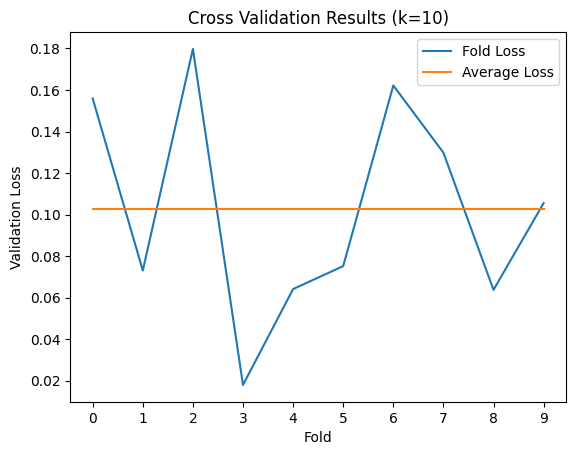

In [ ]:
x_ticks = range(nfolds)
plt.plot(score)
plt.title(f"Cross Validation Results (k={nfolds})")
plt.xlabel("Fold")
plt.ylabel("Validation Loss")
plt.plot([sum(score)/nfolds]*nfolds)
plt.legend(['Fold Loss','Average Loss'])
plt.xticks(ticks=x_ticks)

In [ ]:
print(sum(score)/nfolds)

0.10273311845958233


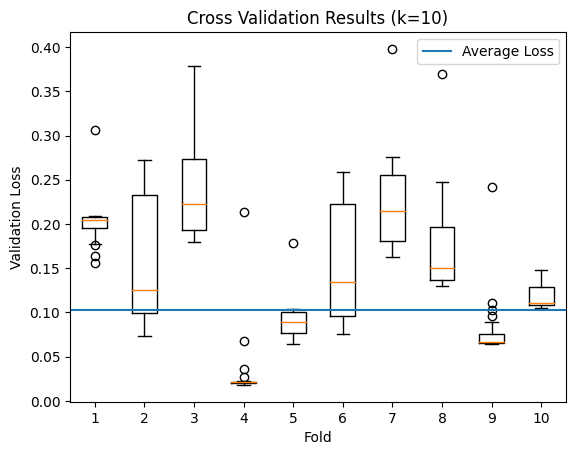

In [ ]:
avg = sum(score)/nfolds
fig, ax = plt.subplots()
plt.title(f"Cross Validation Results (k={nfolds})")
plt.xlabel("Fold")
plt.ylabel("Validation Loss")
plt.boxplot(val_loss)
ax.axline((1, avg), (nfolds, avg), label='Average Loss')
plt.legend()
plt.show()

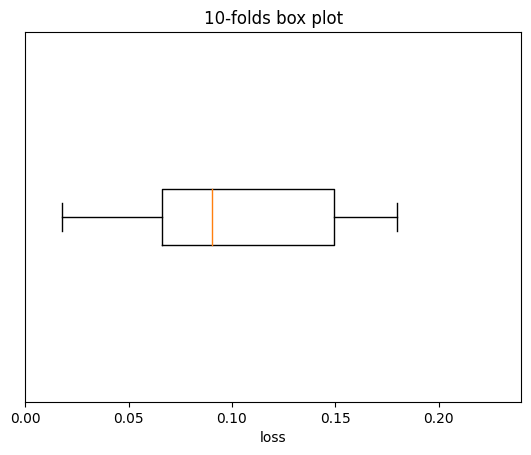

In [ ]:
import matplotlib.patches as mpatches
plt.boxplot(score,vert=False)
plt.xlim(0, 0.24)
plt.title("10-folds box plot")
plt.xlabel("loss")
black_patch = mpatches.Patch(color='black', label = 'Original Model')
red_patch = mpatches.Patch(color='red', label='Alternative Model')
plt.legend(handles=[red_patch, black_patch])
plt.yticks([])
plt.savefig('OriginalModelBoxplot.png', dpi=300)